In [1]:
import numpy as np
import random
from mnist import MNIST
import matplotlib.pyplot as plt

In [2]:
mndata = MNIST('../HW1/Dataset')
trainX = np.array(mndata.load_training()[0])[:50000]
trainY = np.array(mndata.load_training()[1])[:50000]

testX = np.array(mndata.load_testing()[0])[:1000]
testY = np.array(mndata.load_testing()[1])[:1000]

In [3]:
valIndices = np.random.choice(len(trainX), 2000)
nonValIndices = [x for x in range(len(trainX)) if x not in valIndices]

valX = trainX[valIndices]
valY = trainY[valIndices]

trainX = trainX[nonValIndices]
trainY = trainY[nonValIndices]

testX = np.array(mndata.load_testing()[0])[:2000]
testY = np.array(mndata.load_testing()[1])[:2000]

def feat(data,i):
    return data[i].tolist()

def oneHot(clas, noOfClasses):
    feat = np.zeros(noOfClasses)
    feat[clas] = 1;
    return feat

trnX = np.array([feat(trainX,i) for i in range(trainX.shape[0])])/256.0
trnY = np.array([oneHot(trainY[i], 10) for i in range(trainX.shape[0])])

tstX = np.array([feat(testX,i) for i in range(testX.shape[0])])/256.0
tstY = np.array([oneHot(testY[i], 10) for i in range(testX.shape[0])])

valX = np.array([feat(valX,i) for i in range(valX.shape[0])])/256.0
valY = np.array([oneHot(valY[i], 10) for i in range(valX.shape[0])])

In [4]:
trnY[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [72]:
def sigmoid(x):
    return 1.0/(1+np.exp(-1*x))

def lecun(x):
    return 1.7159*np.tanh(2.0*x/3)

def gradSigmoid(x):
    return x*(1-x)

def gradLecun(x):
    t = 2.0*x/3
    return 1.7159*(1-t**2)

def softmax(x):
    x = np.exp(x)
    x = x/x.sum(axis=1)[:, None]
    return x
    
maxValAcc = 0
lr = 0.00001
trnAcc = []
valAcc = []
tstAcc = []

# randomly initialize our weights with mean 0
n_hid_1 = 100
fan_in = 1.0#/np.sqrt(784)
# print fan_in
W1 = fan_in*(2*np.random.random((784,n_hid_1)) - 1)
# print W1
bias = fan_in*(2*np.random.random((n_hid_1)) - 1)
fan_in_h = 1.0#/np.sqrt(n_hid_1)
W2 = fan_in_h*(2*np.random.random((n_hid_1,10)) - 1)
bias2 = fan_in_h*(2*np.random.random((10)) - 1)

prevW1=0
prevW2=0
prevB1=0
prevB2=0

mom=0.5

for j in xrange(300):
    indices = np.random.choice(len(trnX), len(trnX))
    tempY = trnY[indices]
    tempX = trnX[indices]
    A1 = np.dot(tempX, W1 + mom*prevW1) + bias+mom*prevB1
    l1 = lecun(A1)
    
    A2 = np.dot(l1, W2+mom*prevW2) + bias2+mom*prevB2
    l2 = softmax(A2)

    # Errors in output layer
    d2 = (l2 - tempY)
    dbias2 = np.sum(d2, axis = 0)
        
    # Delta of W2
    dW2 = np.dot(l1.T, d2)

    # Errors in 1st hidden layer
    d1 = np.dot(d2, (W2+mom*prevW2).T)*gradLecun(l1)
    dbias = np.sum(d1, axis = 0)    
    
    # Delta W2
    dW1 = np.dot(tempX.T, d1)
    
    currW2=mom*prevW2-lr*dW2
    currB2=mom*prevB2-lr*dbias2
    currW1=mom*prevW1-lr*dW1
    currB1=mom*prevB1-lr*dbias
    
    prevW2=currW2
    prevW1=currW1
    prevB2=currB2
    prevB1=currB1
    
    
    W2 +=currW2
    bias2 +=currB2
    W1 +=currW1
    bias +=currB1
    
    prediction = softmax(np.dot(lecun(np.dot(valX, W1)+bias ), W2)+bias2)
    correct = [1 if a == b else 0 for (a, b) in zip(np.argmax(valY, axis = 1), np.argmax(prediction, axis = 1))]
    valAcc.append(np.sum(correct)*100.0/len(valX))
    
    prediction = softmax(np.dot(lecun(np.dot(trnX, W1)+bias ), W2)+bias2)
    correct = [1 if a == b else 0 for (a, b) in zip(np.argmax(trnY, axis = 1), np.argmax(prediction, axis = 1))]
    trnAcc.append(np.sum(correct)*100.0/len(trnX))   
    
    prediction = softmax(np.dot(lecun(np.dot(tstX, W1)+bias ), W2)+bias2)
    correct = [1 if a == b else 0 for (a, b) in zip(np.argmax(tstY, axis = 1), np.argmax(prediction, axis = 1))]
    tstAcc.append(np.sum(correct)*100.0/len(tstX))   
    
    if(valAcc[-1] > maxValAcc):
        maxValAcc = valAcc[-1]
        maxTestAcc = tstAcc[-1]
    print tstAcc[-1]," ",valAcc[-1]

23.65   26.25
29.9   31.65
39.9   42.1
45.85   47.3
50.9   55.45
53.8   56.7
56.3   60.25
59.65   61.7
60.0   63.3
63.6   65.45
63.75   67.85
65.15   66.9
65.75   68.4
67.4   70.9
67.7   71.3
67.8   70.3
68.75   72.25
70.0   73.55
70.55   72.2
72.0   74.6
72.35   74.8
71.15   73.9
71.95   74.55
71.2   74.65
72.9   75.45
71.55   74.8
73.6   77.15
72.1   75.45
74.3   78.45
73.25   76.85
74.7   78.85
74.15   77.55
75.55   79.75
75.25   78.75
75.8   79.6
75.25   79.2
75.9   80.25
76.05   79.9
75.85   80.5
76.7   80.65
76.55   81.25
77.55   81.2
76.9   82.1
78.45   82.35
77.5   82.65
78.6   83.2
77.75   82.9
78.45   83.4
78.3   83.15
78.1   82.9
78.1   83.5
77.7   82.0
78.0   83.3
78.5   82.35
78.85   84.0
79.0   83.35
79.2   84.15
79.3   83.2
78.8   83.85
79.35   83.0
78.0   83.45
79.4   82.95
77.15   82.45
78.95   82.5
76.0   81.5
80.1   84.1
78.6   83.7
81.4   85.35
80.5   85.7
81.6   85.6
81.5   86.5
81.5   85.85
81.75   86.35
82.05   86.1
81.9   86.75
82.15   86.2
81.95   87.0
82.2   8

KeyboardInterrupt: 

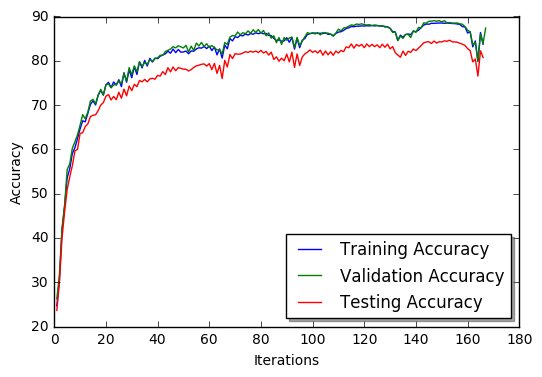

In [73]:
plt.plot([x+1 for x in range(len(trnAcc))], trnAcc, label = 'Training Accuracy')
plt.plot([x+1 for x in range(len(valAcc))], valAcc, label = 'Validation Accuracy')
plt.plot([x+1 for x in range(len(tstAcc))], tstAcc, label = 'Testing Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', shadow=True)
plt.show()

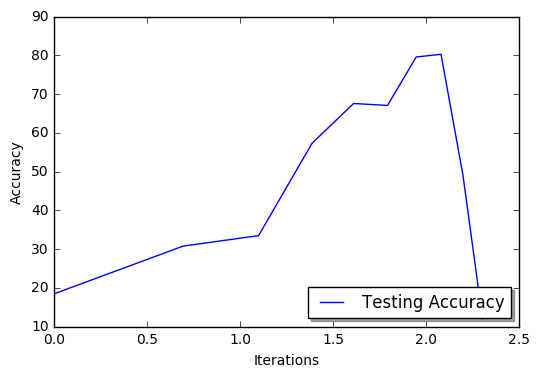

In [24]:
plt.plot([np.log(x+1) for x in range(10)], maxTestAcc, label = 'Testing Accuracy')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='lower right', shadow=True)
plt.show()